In [289]:
# check out the supporting article here: 
# https://grahammr93.medium.com/can-us-state-gdp-determine-congressional-representation-e3cda57285f3

import pandas as pd
import openpyxl
import states
import scipy.stats as st
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import squarify

In [253]:
# !pip install squarify

## Get and clean up data

In [224]:
# read in files
gdp = pd.read_csv("gdp_by_state.csv")  # https://apps.bea.gov/regional/downloadzip.cfm
legislators = pd.read_csv("legislators-current.csv")  # https://data.world/govtrack/us-congress-legislators/workspace/file?filename=legislators-historical.csv
states_df = pd.Series(states.us_state_to_abbrev).reset_index()  # https://gist.github.com/rogerallen/1583593

In [225]:
# rename gdp fields when needed, review quarters --> states are names
gdp.rename(columns={'Unnamed: 1': 'Currency'}, inplace=True)  # probably don't need this
# remove 
gdp.drop(columns="GeoFips", inplace=True)
gdp.set_index("GeoName", inplace=True)
# gdp

In [226]:
# transpose for ease
gdpt = gdp.transpose()
gdpt = gdpt[1:]
# gdpt

In [227]:
state_gdp = gdpt.sum().reset_index()
# state_gdp

In [228]:
# look at legislators --> states are abbreviations
# legislators

In [229]:
# get designated states dataframe to convert abbreviations to names
states_df.columns = ['StateName', 'StateAbbrev']
# states_df

In [230]:
gdp_summary = state_gdp.merge(states_df, how="inner", left_on="GeoName", right_on="StateName")
# gdp_summary

# validated_states = gdp_summary.StateName.values
# len(validated_states)

In [231]:
joined_leg = legislators.merge(gdp_summary, how="left", left_on="state", right_on="StateAbbrev")

#expect 540 rows returned
len(joined_leg)

540

In [232]:
# joined_leg

## EDA

### GDP

<AxesSubplot:>

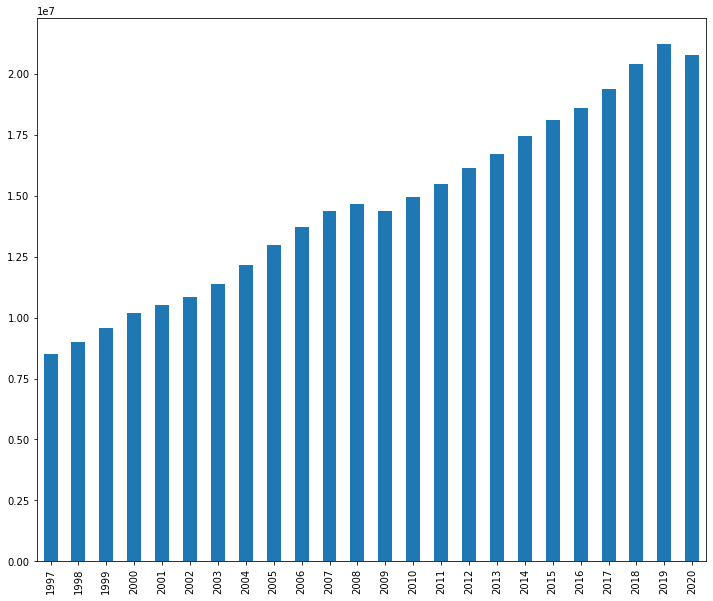

In [233]:
gdp.T.sum(axis=1).plot(kind="bar", figsize=(12,10))

C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


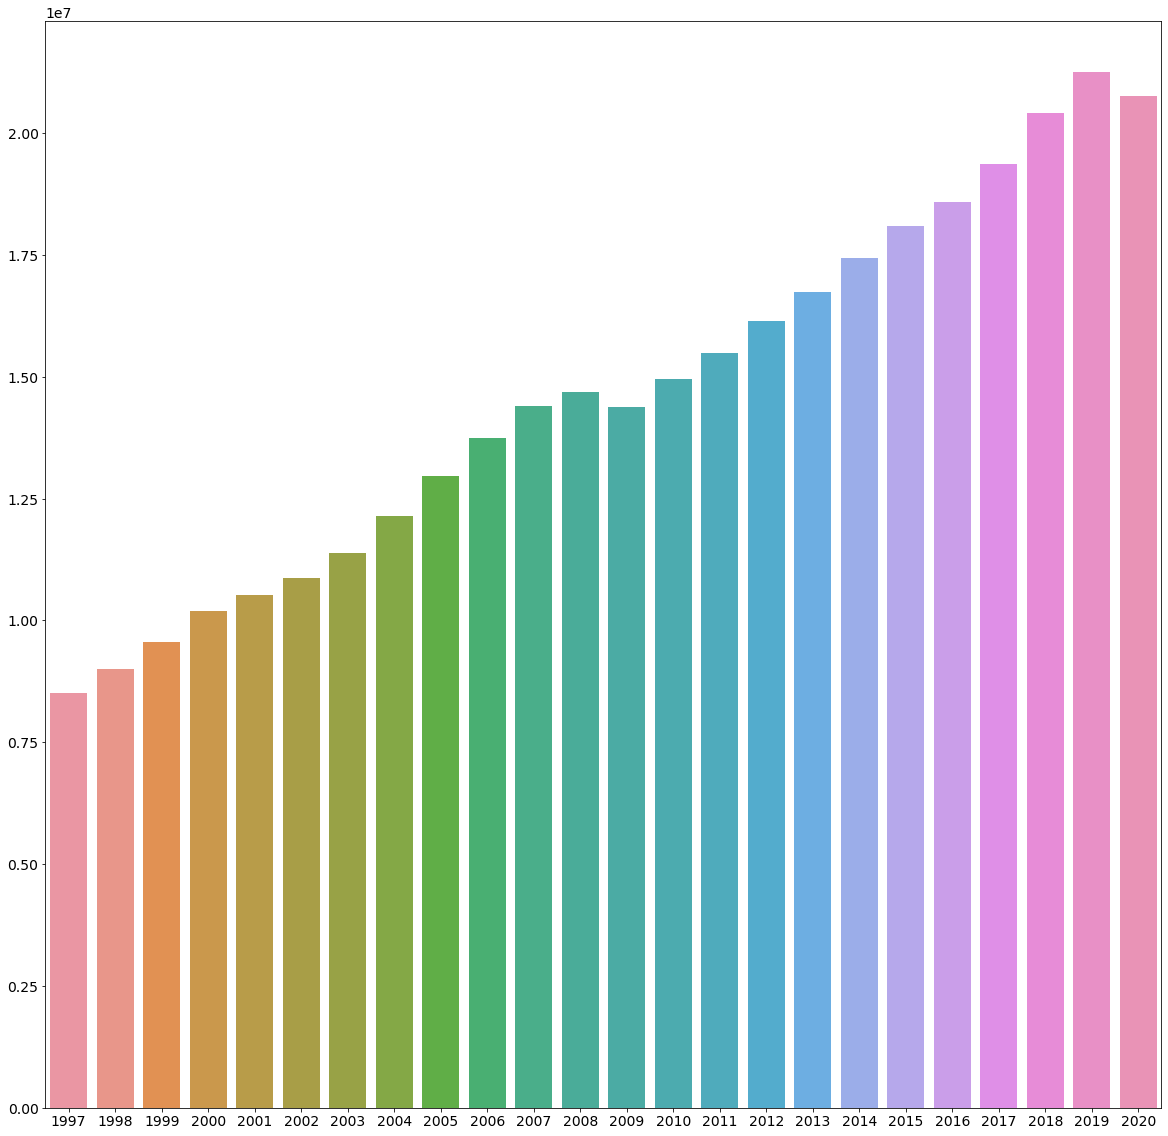

In [300]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
sns.barplot(gdp.T.index.values, gdp.T.sum(axis=1))
plt.show()

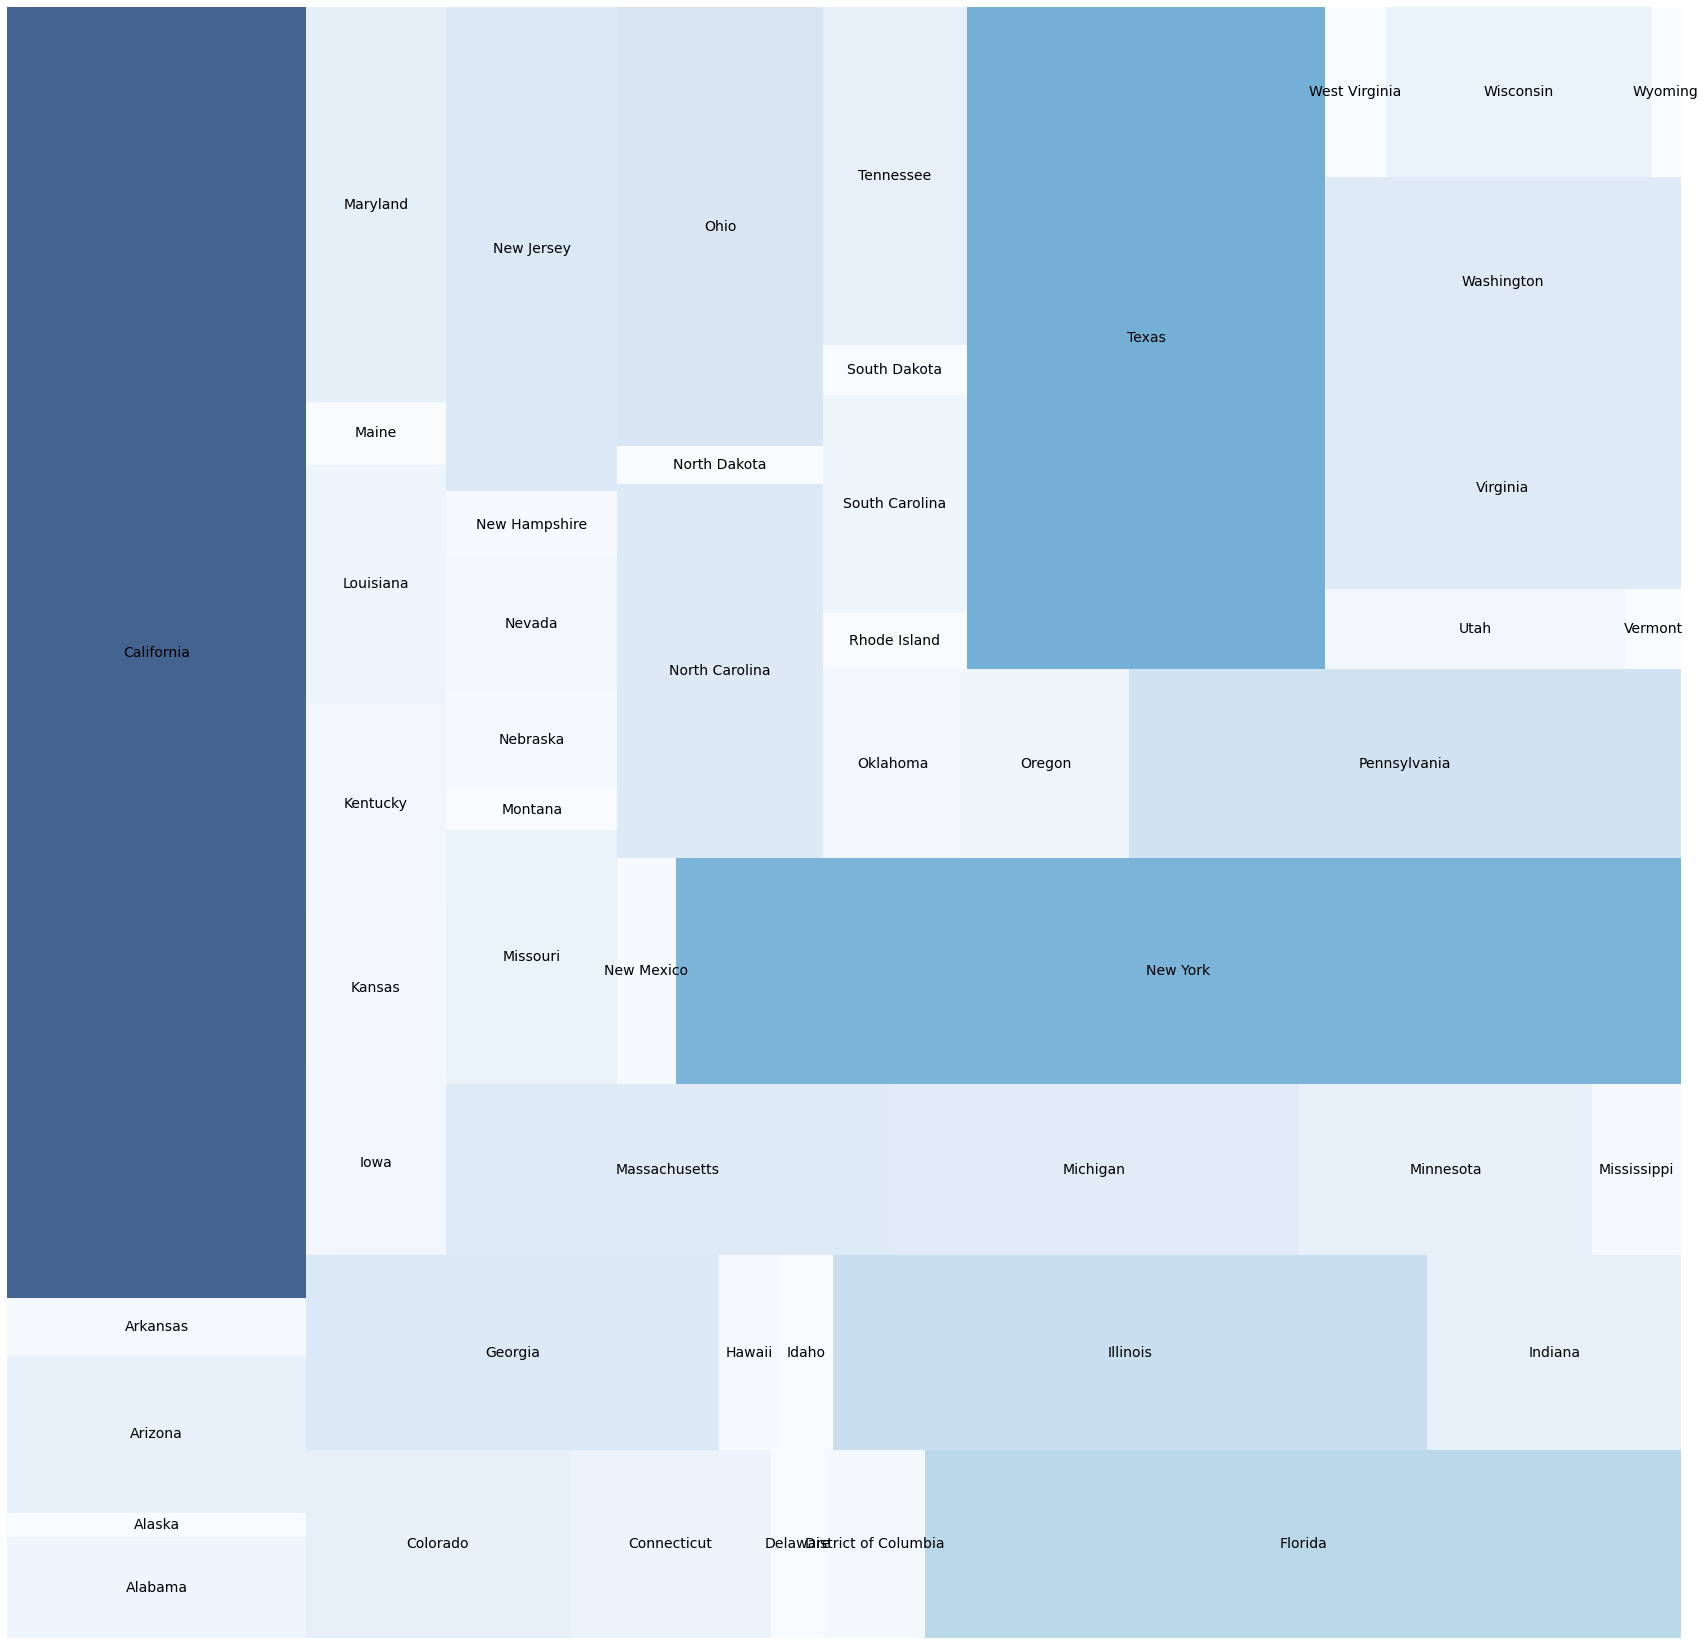

In [291]:

labels = gdp.index.values.tolist()

# create a color palette, mapped to these values
cmap = plt.cm.Blues
mini=min(gdp.loc[:, '2015':].sum(axis=1))
maxi=max(gdp.loc[:, '2015':].sum(axis=1))
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in gdp.loc[:, '2015':].sum(axis=1)]
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
squarify.plot(sizes=gdp.loc[:, '2015':].sum(axis=1), ax=ax, label=labels, alpha=0.75, color = colors)
plt.axis('off')
# plt.rc('font', size = 14)
plt.show()

In [301]:
# state_gdp
# gdp.loc[:, '2015':].sum(axis=1).sort_values(ascending=False).plot(kind="bar", figsize=(20,20))

In [320]:
# setting total GDP sum
tot_gdp = gdp.loc[:, '2015':].sum().sum()

# create proportion table to calculate expected representatives
gdp_prop = gdp.loc[:, '2015':].sum(axis=1) / tot_gdp

#### Determine total contribution to GDP

In [321]:
# convert series to dataframe, give it a name
gdp_prop = pd.DataFrame(gdp_prop, columns=['PercGDPCont'])
# view by sort for ease
gdp_prop

,PercGDPCont
GeoName,
Alabama,0.011033
Alaska,0.002654
Arizona,0.017192
Arkansas,0.006316
California,0.141227
Colorado,0.018114
Connecticut,0.013845
Delaware,0.003675
District of Columbia,0.006892


<AxesSubplot:xlabel='GeoName'>

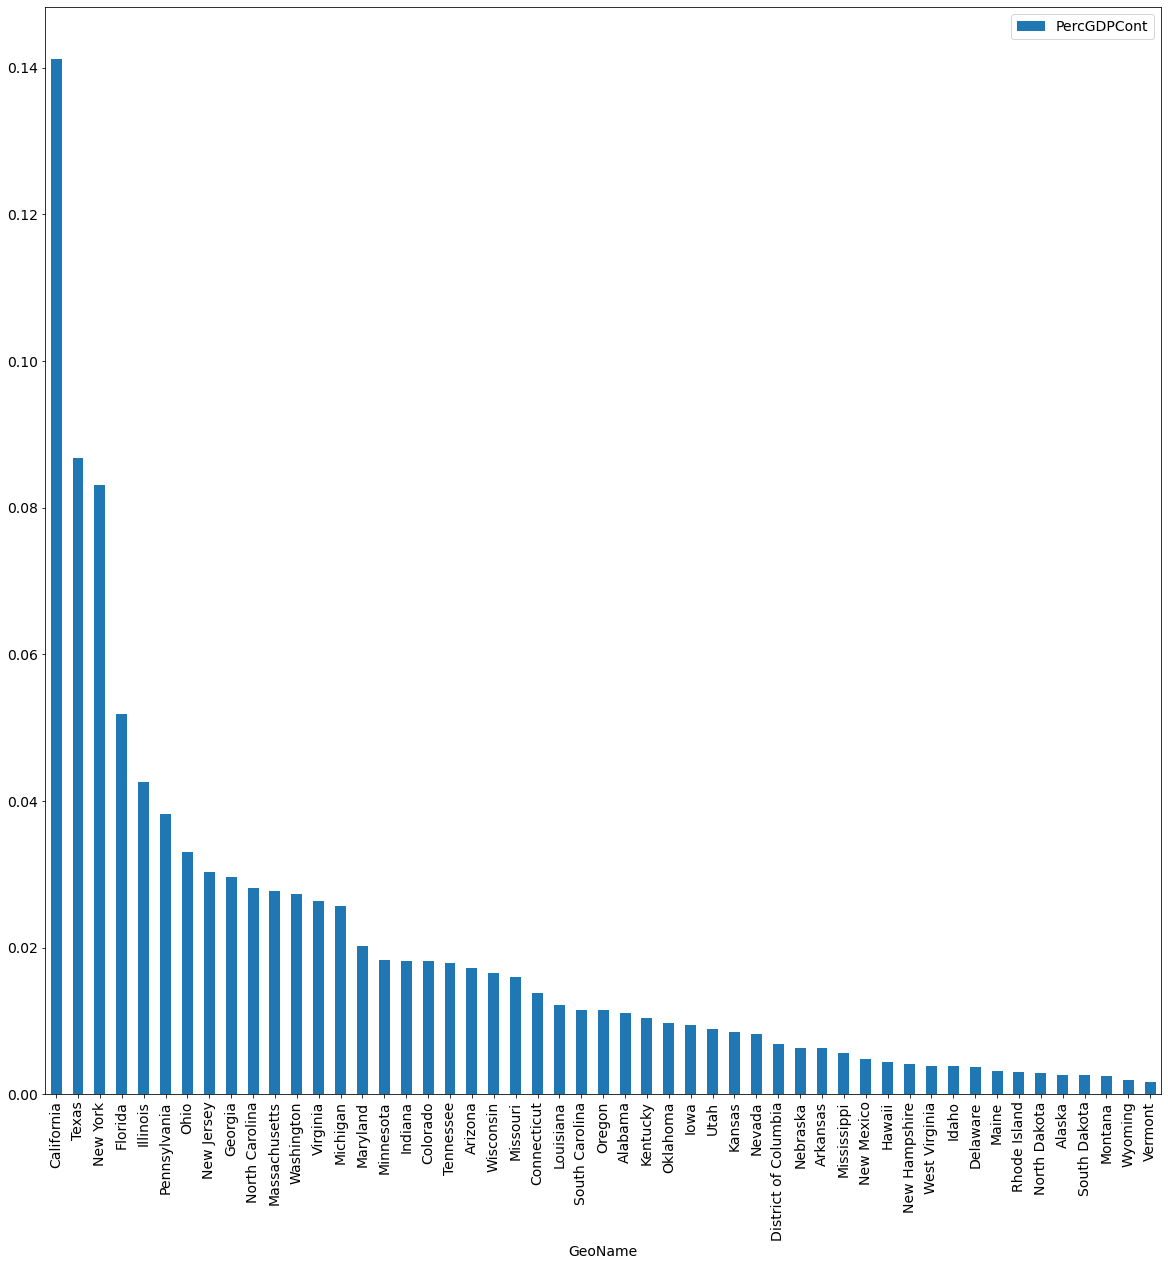

In [327]:
gdp_prop.sort_values(by=["PercGDPCont"], ascending=False).plot(kind="bar", figsize=(20,20))

In [324]:
# fig = plt.figure(figsize=(30,30))
# ax = fig.add_subplot(111)
# sns.barplot(gdp_prop.index.values, gdp_prop.PercGDPCont.values)
# plt.show()

#### Gather all values for calculations

In [238]:
# get all representatives in congress
total_cong = len(legislators[legislators['type'] == 'rep'])

# calculate expected rep congress
expected_cong = gdp_prop * total_cong
expected_cong.columns = ['expCong']

# get actual rep in congress size
act_cong = pd.Series(joined_leg.groupby('StateName').size(), name='act_cong')

# get actual republican congress people
reps = pd.Series(joined_leg[joined_leg.party == "Republican"].groupby('StateName').size(), name='act_rs')

## Determining misrepresentation

In [239]:
# create comparison table for plots
comp_tab = pd.concat([expected_cong, act_cong], axis=1)
# join with actual republicans
comp_tab = pd.concat([comp_tab, reps], axis=1)
# determine representation. positive number means over-representation by GDP
comp_tab['diff'] = comp_tab['act_cong'] - comp_tab['expCong']
# get percent republican to see if difference between higher and lower perc_r states
comp_tab['perc_r'] = comp_tab['act_rs'] / comp_tab['act_cong']
# view by difference
comp_tab.sort_values(by=['diff'], ascending=True)
comp_tab = comp_tab.round(4)
comp_tab

,expCong,act_cong,act_rs,diff,perc_r
Alabama,4.8546,9,8.0,4.1454,0.8889
Alaska,1.1678,3,3.0,1.8322,1.0000
Arizona,7.5645,11,4.0,3.4355,0.3636
Arkansas,2.7791,6,6.0,3.2209,1.0000
California,62.1397,54,10.0,-8.1397,0.1852
Colorado,7.9703,9,3.0,1.0297,0.3333
Connecticut,6.0916,7,NaN,0.9084,NaN
Delaware,1.6171,3,NaN,1.3829,NaN
District of Columbia,3.0325,1,NaN,-2.0325,NaN
Florida,22.8246,29,18.0,6.1754,0.6207


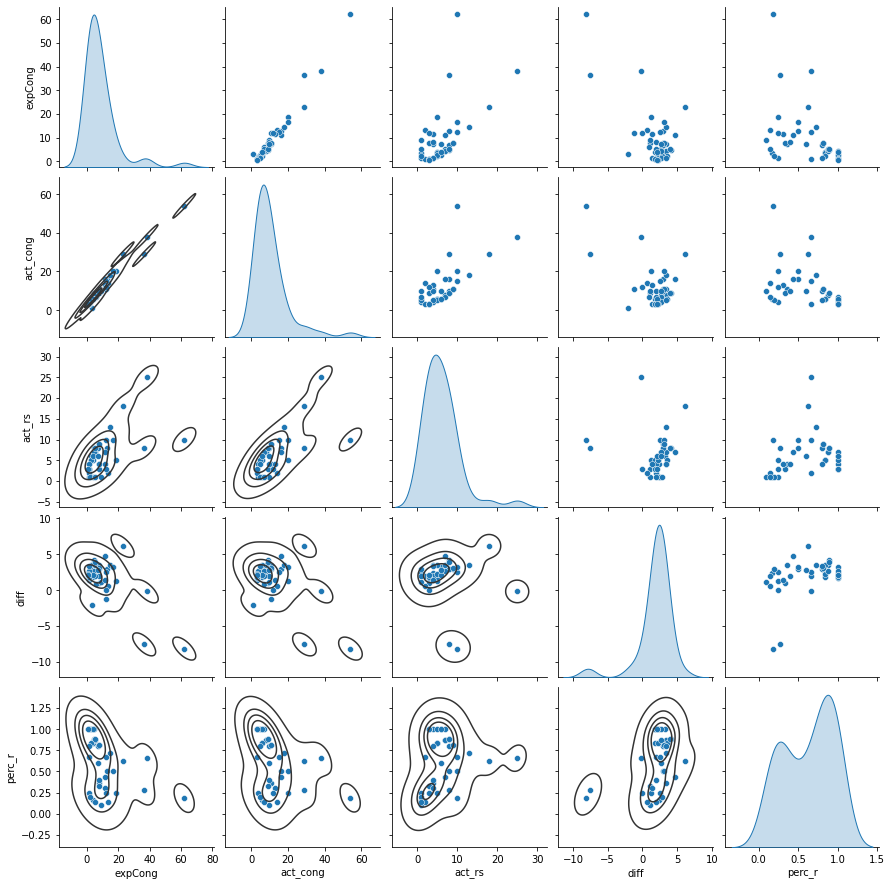

In [240]:
# try plotting
g = sns.pairplot(comp_tab, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=5, color=".2")

In [241]:
# sns.scatterplot(x=comp_tab['act_rs'], y=comp_tab['diff'])

In [334]:
# Goodness of fit test
k = len(comp_tab)
df_k = k - 1
alpha = 0.05

crit_val = round(st.chi2.ppf(1 - alpha, df_k), 4)
print(f"Critical value: {crit_val}")

chi_sq_calc = sum( ( (comp_tab.expCong.values - comp_tab.act_cong.values)**2) / comp_tab.act_cong.values)
print(f"Test statistic: {round(chi_sq_calc, 4)}")

claim = "there is a significant difference between observed and expected values"

if chi_sq_calc > crit_val:
    print(f"At alpha = {alpha}, there is sufficient evidence to state {claim}")
else:
    print(f"At alpha = {alpha}, there is not sufficient evidence to state {claim}")

print(f"P-value: {1 - st.chi2.cdf(chi_sq_calc, df_k)}")

Critical value: 67.5048
Test statistic: 52.5179
At alpha = 0.05, there is not sufficient evidence to state there is a significant difference between observed and expected values
P-value: 0.37670628809279605


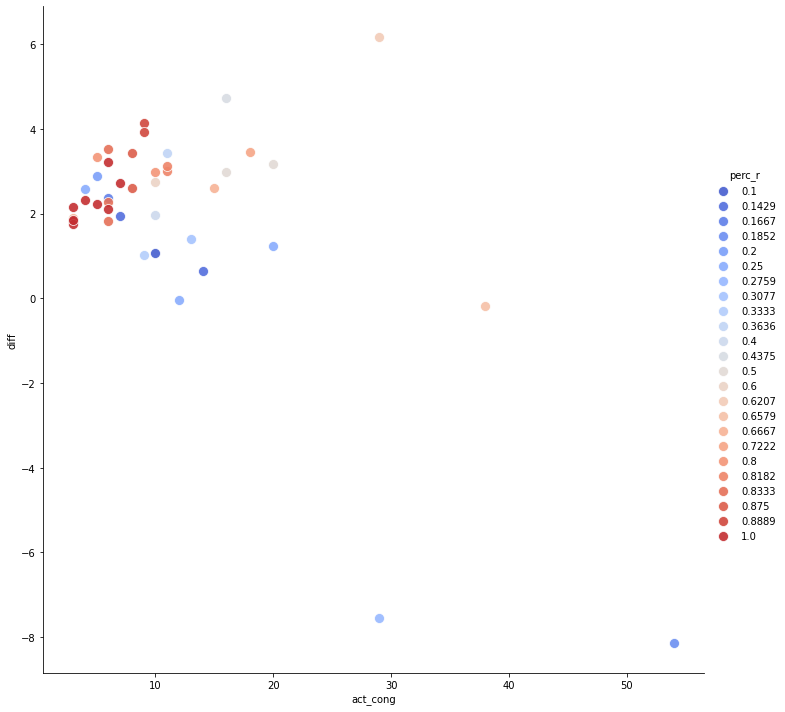

In [243]:
g = sns.FacetGrid(comp_tab, hue="perc_r", height=10, palette="coolwarm")
g.map(sns.scatterplot, "act_cong", "diff", s=100, alpha=.9)
g.add_legend()

#### Hypothesis testing

In [330]:
# test to see if republican states are more likely to have a difference than not

# Ho: rep = .5
# Ha: rep > .5

# get proportion of states that have difference > 0
over_rep_states = comp_tab[comp_tab['diff'] > 0]
over_rep_r_states = comp_tab[(comp_tab['diff'] > 0) & (comp_tab['perc_r'] > 0.5)]

tot_over_rep_states = len(over_rep_states)
tot_over_rep_r_states = len(over_rep_r_states)

prop_r_over_rep = tot_over_rep_r_states / tot_over_rep_states
print(f"Observed proportions: {round(prop_r_over_rep, 4)}")

Observed proportions: 0.5556


In [336]:
n = len(comp_tab)
p = 0.5
alpha = 0.05

# determine test type
np = n * p #  needs to be > 5 for z
nq = n * (1 - p) #  AND needs to be > 5 for z

print(f"np: {np}\nnq: {nq}")

# print(f"{np}, {nq}")
# since np and nq are both greater than 5, we can use z-tests 
s = math.sqrt( p * (1 - p) / n)

# find critical value
cv = abs(round(st.norm.ppf(alpha), 4))
print(f"Critical value: {cv}")

# calculate test statistic
z_score =  round((prop_r_over_rep - p) / s, 4)
print(f"Z score: {z_score}")

# get p-value
p_val = round(1 - st.norm.cdf(z_score), 4)
print(f"P value: {p_val}")

np: 25.5
nq: 25.5
Critical value: 1.6449
Z score: 0.7935
P value: 0.2137


No sufficient evidence to conclude that that republican states are more likely to be misrepresented

# More tbd

## Legislators

In [246]:
legislators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   last_name           540 non-null    object 
 1   first_name          540 non-null    object 
 2   middle_name         247 non-null    object 
 3   suffix              18 non-null     object 
 4   nickname            42 non-null     object 
 5   full_name           540 non-null    object 
 6   birthday            540 non-null    object 
 7   gender              540 non-null    object 
 8   type                540 non-null    object 
 9   state               540 non-null    object 
 10  district            440 non-null    float64
 11  senate_class        100 non-null    float64
 12  party               540 non-null    object 
 13  url                 537 non-null    object 
 14  address             540 non-null    object 
 15  phone               540 non-null    object 
 16  contact_

<AxesSubplot:xlabel='state'>

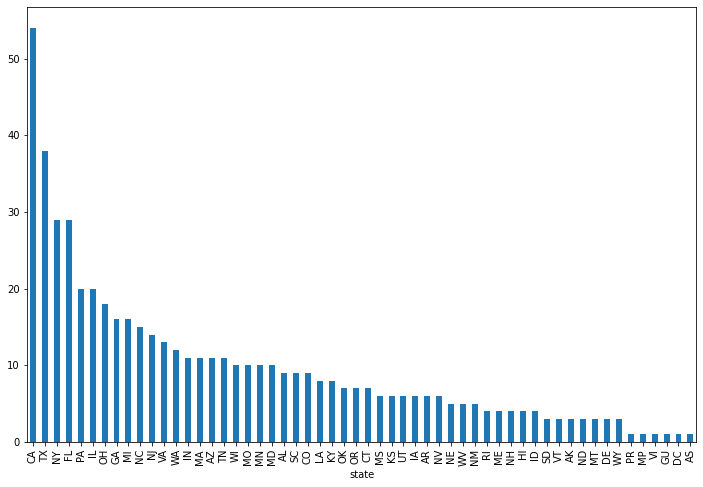

In [247]:
legislators.groupby('state').size().sort_values(ascending=False).plot(kind='bar', figsize=(12,8))

<AxesSubplot:xlabel='gender', ylabel='count'>

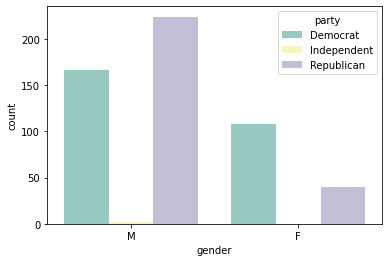

In [248]:
# fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# plt.figure(figsize=(10,8))
sns.countplot(x='gender', palette="Set3", hue='party', data=joined_leg)

<AxesSubplot:xlabel='type', ylabel='count'>

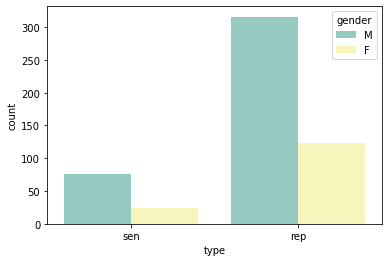

In [249]:
sns.countplot(x='type', palette="Set3", hue='gender', data=joined_leg)

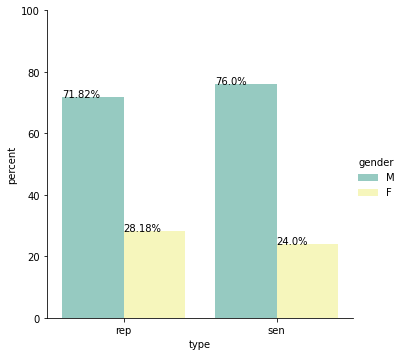

In [250]:
x,y = 'type', 'gender'

df1 = joined_leg.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar', palette="Set3", data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)